In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

In [23]:
#define the columns to keep from the files when processing the data with pandas library
columns = ['Ns', 'mode', 'Efficiency/%', 'Ewe/V', 'Q_discharge/mA.h', 'Q_charge/mA.h', 'time/s']

#variables to filter the data
StepCh_cycle2 = ['4']
Step_FullDch = ['3']
StepDch_p1 = ['5']
StepDch_p2 = ['7']
Task_rest = ['3']
Task_cycling = ['1']
Step_discharges = ['5', '7']
step_Rest = ['6']

In [24]:
#create the system path to reach all the files saved in Capacity Loss folder
data_path = Path('Capacity Loss_VSP 300')

#load the files in file_list list to allow access to test data
file_list = [file for file in data_path.iterdir() if file.is_file()]

for file in file_list:
    print(file) #show the files contained in file_list

Capacity Loss_VSP 300\20250130_CapacityLoss_Cell A3_LowVolt_C01 2.txt
Capacity Loss_VSP 300\20250207_CapacityLoss_Cell A3_LowVolt_C01.txt


In [ ]:
Capacity_Lost_list = []

for file in file_list:
        #create dataframe df from files
    df = pd.read_csv(file, sep = r'\s+', usecols = columns)
        #pre-filtering of data contained in df against tasks variable
    
    # Filter data for the corresponding step
    df_Ch = df[(df['Ns'] == 4) & (df['mode'] == 1)]
    df_Dch = df[(df['Ns'] == 3) & (df['mode'] == 1)]
    df_Dch1 = df[(df['Ns'] == 5) & (df['mode'] == 1)]
    df_Dch2 = df[(df['Ns'] == 7) & (df['mode'] == 1)]
    df_efficiency = df[(df['Ns'] == 7) & (df['mode'] == 3)]
    df_storage = df[(df['Ns'] == 6) & (df['mode'] == 3)]

    # Extract the coulombic efficiency using the index location
    Coul_Eff = np.max(df_efficiency['Efficiency/%'])

    # Extract storage duration for later
    Storage_time = round((np.max(df_storage['time/s']) - np.min(df_storage['time/s']))/(3600*24))

    # Extract the capacity data
    Q_FullCh = np.max(df_Ch['Q_charge/mA.h'])
    Q_FullDch = np.max(df_Dch['Q_discharge/mA.h'])
    Qdch_part1 = np.max(df_Dch1['Q_discharge/mA.h'])
    Qdch_part2 = np.max(df_Dch2['Q_discharge/mA.h']) - Qdch_part1

    #process
    Theoric_Capacity_discharged = Q_FullCh * (Coul_Eff/100) /1000
    Total_Capacity_remaining = Qdch_part1/1000 + Qdch_part2/1000
    Capacity_lost_after_storage = Q_FullDch/1000 - (Qdch_part1/1000 + Qdch_part2/1000)
    Capacity_Lost_list.append((Capacity_lost_after_storage, file, Storage_time))

    print(f'\033[1m{Path(file).stem}\033[0m\n'
          f' - Full capacity charged: {Q_FullCh/1000:.4f} Ah\n' 
          f' - Full capacity discharged: {Theoric_Capacity_discharged:.4f} Ah\n' 
          f' - Capacity retained after storage: {Total_Capacity_remaining:.4f} Ah\n' 
          f' * Capacity lost during storage ({Storage_time} days): {Capacity_lost_after_storage / Storage_time:.4f} Ah\n'
          f' * Coulombic efficiency: \033[1m{Coul_Eff:.4f}%\033[0m\n'
          f' # \033[1mCapacity discharged during partial discharges\033[0m\n'
          f' # Q1 = {Qdch_part1/1000:.4f} Ah, Q2 = {Qdch_part2/1000:.4f} Ah\n')

20250130_CapacityLoss_Cell A3_LowVolt_C01 2
 - Full capacity charged: 39.8480 Ah
 - Full capacity discharged: 39.6001 Ah
 - Capacity retained after storage: 39.7450 Ah
 * Capacity lost during storage (3 days): 0.1027 Ah
 * Coulombic efficiency: 99.3779%
 # Capacity discharged during partial discharges
 # Q1 = 25.0092 Ah, Q2 = 14.7357 Ah

20250207_CapacityLoss_Cell A3_LowVolt_C01
 - Full capacity charged: 39.5500 Ah
 - Full capacity discharged: 39.4986 Ah
 - Capacity retained after storage: 39.6421 Ah
 * Capacity lost during storage (2 days): 0.0713 Ah
 * Coulombic efficiency: 99.8702%
 # Capacity discharged during partial discharges
 # Q1 = 20.0134 Ah, Q2 = 19.6287 Ah



20250130_CapacityLoss_Cell A3_LowVolt_C01 2
 Values of data point for Discharge_part1
  Capacity = 25.009 Ah, Cell potential = 3.24642 V
 Values of data point for Discharge_part2
  Capacity = 25.317 Ah, Cell potential = 3.24552 V
 Cell potential decrease upon storage (3 days) = 0.299548 mV per day



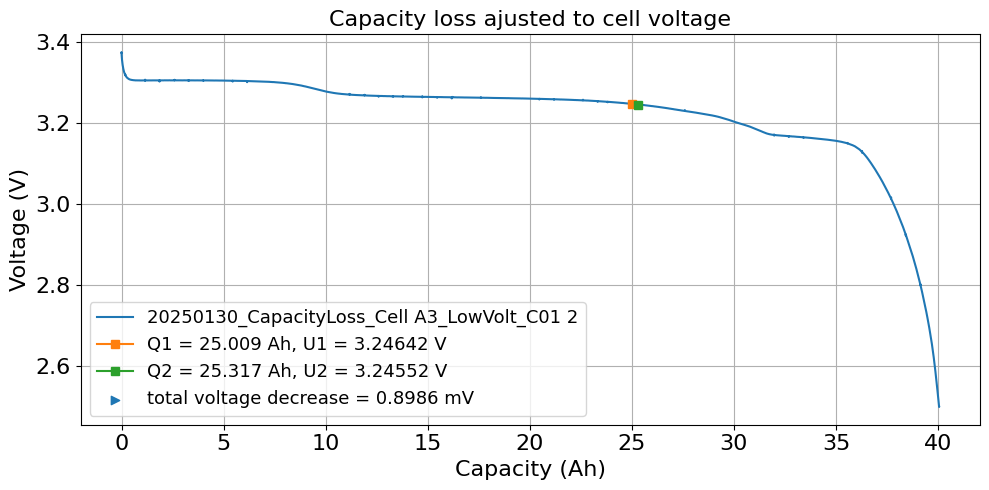

20250207_CapacityLoss_Cell A3_LowVolt_C01
 Values of data point for Discharge_part1
  Capacity = 20.013 Ah, Cell potential = 3.25965 V
 Values of data point for Discharge_part2
  Capacity = 20.156 Ah, Cell potential = 3.25929 V
 Cell potential decrease upon storage (2 days) = 0.183534 mV per day



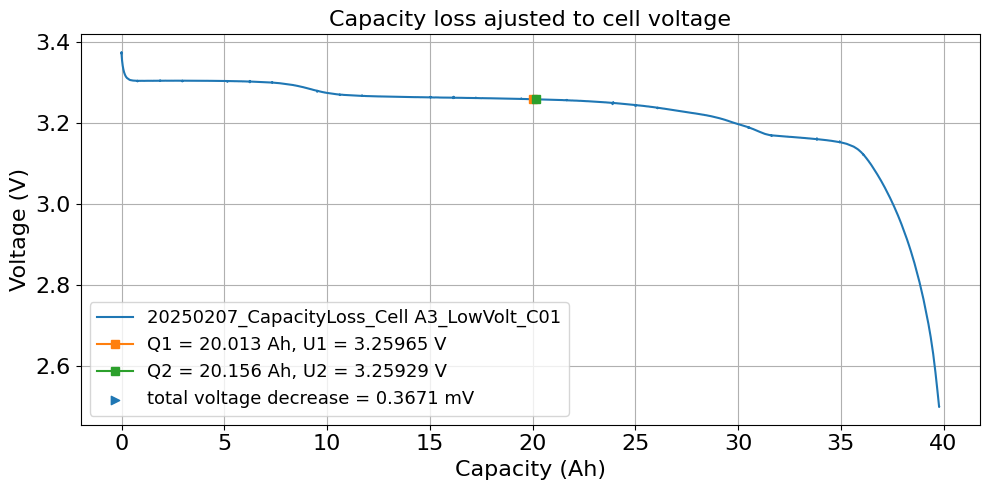

In [ ]:
for capacity_lost, file, Storage_time in Capacity_Lost_list:
    plt.figure(figsize=(10, 5))
    size = 16

    #print(capacity_lost, file)
    #create dataframe df from files
    df = pd.read_csv(file, sep = r'\s+', usecols = columns)

    Voltage_df = df[(df['Ns'] == 3) & (df['mode'] == 1)]
    Capacity_df = df[(df['Ns'] == 3) & (df['mode'] == 1)]

    Voltage = Voltage_df['Ewe/V']
    Capacity = Capacity_df['Q_discharge/mA.h']/1000

    Qdch_p1_df = df[df['Ns'] == 5]
    Capacity_Dch1 = np.max(Qdch_p1_df['Q_discharge/mA.h'])
    QDch_p1 = df[df['Q_discharge/mA.h'] == Capacity_Dch1]
    Voltage_Dch1 = QDch_p1['Ewe/V'].values[0]

    Capacity_after_storage = Capacity_Dch1/1000 + capacity_lost
    Rectified_Voltage = np.interp(Capacity_after_storage, Capacity, Voltage)

    print(f'\033[1m{Path(file).stem}\033[0m\n'
        f' \033[1mValues of data point for Discharge_part1\033[0m\n'
        f'  Capacity = {Capacity_Dch1/1000:.3f} Ah, Cell potential = {Voltage_Dch1:.5f} V\n'
        f' \033[1mValues of data point for Discharge_part2\033[0m\n'
        f'  Capacity = {Capacity_after_storage:.3f} Ah, Cell potential = {Rectified_Voltage:.5f} V\n'
        f' \033[1mCell potential decrease upon storage ({Storage_time} days) = {((Voltage_Dch1 - Rectified_Voltage)*1000)/Storage_time:5f} mV per day\033[0m\n'
        )

    # Create the graphs
    plt.plot(Capacity, Voltage, label = Path(file).stem)
    plt.plot(Capacity_Dch1/1000, Voltage_Dch1, marker = 's', label = (f'Q1 = {Capacity_Dch1/1000:.3f} Ah, U1 = {Voltage_Dch1:.5f} V'))
    plt.plot(Capacity_after_storage, Rectified_Voltage, marker = 's', label = (f'Q2 = {Capacity_after_storage:.3f} Ah, U2 = {Rectified_Voltage:.5f} V'))
    plt.scatter([], [], marker = '>', label = (f'total voltage decrease = {(Voltage_Dch1 - Rectified_Voltage)*1000:.4f} mV'))

    #plt.xlim(24, 26.5)
    #plt.ylim(3.1, 3.3)
    plt.xlabel('Capacity (Ah)', fontsize = size)
    plt.ylabel('Voltage (V)', fontsize = size)
    plt.title('Capacity loss ajusted to cell voltage', fontsize = 16)
    #plt.xticks(rotation=45)
    plt.xticks(fontsize = size)
    plt.yticks(fontsize = size)
    plt.legend(loc = 'lower left',fontsize = 13)
    plt.tight_layout()

    plt.grid()
    plt.show()